## Setup

#### Imports

In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Camera Calibration

In [4]:
images =  [mpimg.imread('camera_cal/' + file) for file in os.listdir('camera_cal')]
patternSize = (9,6)
objpoints = []
imgpoints = []
for image in images:
    gray = cv2.cvtColor(image ,cv2.COLOR_RGB2GRAY)
    retval, corners = cv2.findChessboardCorners(gray, patternSize)
    if retval:
        objpoints.append(np.float32([(x,y,0) for y in range(patternSize[1]) for x in range(patternSize[0])]))
        imgpoints.append(np.float32([corner[0] for corner in corners]))

ret, camera_matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

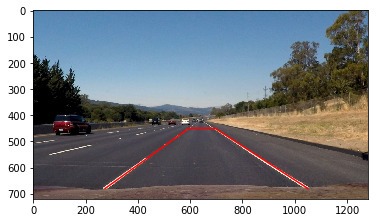

In [5]:
test_images = [mpimg.imread('test_images/' + filename) for filename in os.listdir('test_images')]
for image in test_images[2:]:
    plt.figure()
    plt.imshow(image)
    points = [[275, 680], [595, 450], [695, 450], [1050, 680]]
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    plt.plot(x, y, color='red')
    break

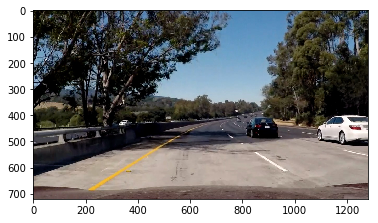

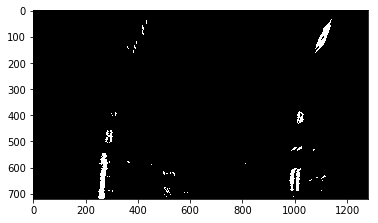

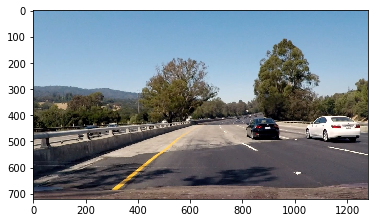

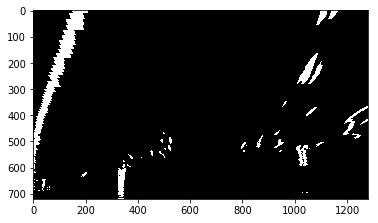

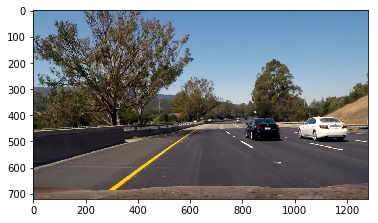

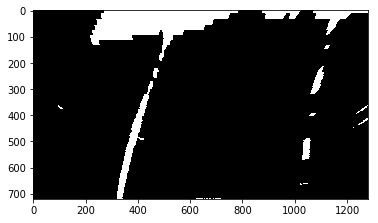

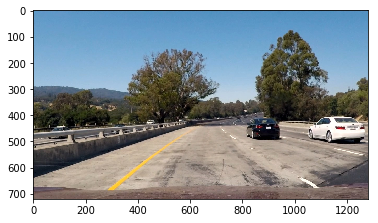

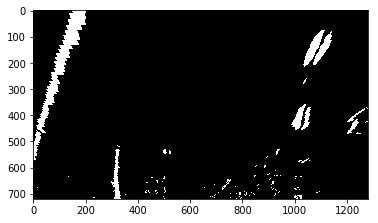

In [118]:
def warp_image(image):
    src = np.float32([[275, 680], [595, 450], [695, 450], [1050, 680]])
    dst = np.float32([[300, 720], [300, 0], [980, 0], [980, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (1280, 720))
    return warped
    
def pipeline(image):
    image = cv2.undistort(image, camera_matrix, distortion)
    
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hue = image[:,:,0]
    lightness = image[:,:,1]
    saturation = image[:,:,2]
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobelx = np.uint8(abs_sobelx / np.max(abs_sobelx) * 255)
    scaled_sobely = np.uint8(abs_sobely / np.max(abs_sobely) * 255)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)
    
    x_index = np.float32([[x for x in range(gray.shape[1])] for y in range(gray.shape[0])])
    y_index = np.float32([[y for x in range(gray.shape[1])] for y in range(gray.shape[0])])
                       
    binary_output = np.zeros_like(gray)
    saturation_straddle = (saturation < 80) | (saturation > 200)
    grey_thresh = (gray > 100)
    lightness_thresh = (lightness > 150)
    hue_thresh = (hue > 150)
    x_index_thresh = (x_index > 0)
    y_index_thresh = (y_index > 300)
    scaled_sobel_mag_thresh = (scaled_sobel_mag > 50)
    sobel_angle_thresh = (sobel_angle > 0.7) & (sobel_angle < 1.3)
    
    binary = np.zeros_like(gray)
    search = (hue > 150) # start simple
    binary[search] = 1

    warped = warp_image(binary)
    if np.count_nonzero(warped) < 720 * 1280 // 5:
        return warped
    else:
        binary = np.zeros_like(gray)
        yellow_line_search =(red > 130) & (green > 130) & (blue < 100) # for yellow line
        search = (saturation > 100) & (hue > 150) & (red > 150) & (scaled_sobelx > 20) | yellow_line_search
        binary[search] = 1
        warped = warp_image(binary)
        return warped
    
test_images = [mpimg.imread('test_images/' + filename) for filename in os.listdir('test_images')]
for i, image in enumerate(test_images):
    hard = (0,1,6,7)
    easy = (2,3,4,5)
    if i in hard:
        binary = pipeline(image)
        plt.figure()
        plt.imshow(image)
        plt.figure()
        plt.imshow(binary, cmap='gray')
#         poly = polyfit(binary)

In [109]:
def polyfit(binary):
    # Use peaks of column activations to determine lane start points
    colsums = np.sum(binary, axis=0)
    midpoint = binary.shape[1] // 2
    left_current = np.argmax(colsums[0:midpoint])
    right_current = np.argmax(colsums[midpoint:]) + midpoint
    
    # Use sliding windows to identify lane points
    nwindows = 10
    window_height = binary.shape[0] // nwindows
    left_points = []
    right_points = []
    for n in range(nwindows, 0, -1):
        bottom = window_height * n
        top = window_height * (n-1)
        left_box = binary[top:bottom, left_current-100: left_current+100]
        right_box = binary[top:bottom, right_current-100: right_current + 100]
        lefts = np.transpose(np.nonzero(left_box)) + [top, left_current-100]
        rights = np.transpose(np.nonzero(right_box)) + [top, right_current-100]
        left_points.append(lefts)
        right_points.append(rights)
        if len(lefts) > 0:
            left_current = int(np.mean(lefts[:,1]))
        if len(rights) > 0:
            right_current = int(np.mean(rights[:,1]))
    left_points = np.concatenate(left_points)
    right_points = np.concatenate(right_points)
    plt.plot(left_points[:,1], left_points[:,0], 'ro')
    plt.plot(right_points[:,1], right_points[:,0], 'ro')
    
    # Fit a polynomial to the lane points
    left_poly = np.polyfit(left_points[:,0], left_points[:,1], 2)
    right_poly = np.polyfit(right_points[:,0], right_points[:,1],2)
    left_calc = np.poly1d(left_poly)
    right_calc = np.poly1d(right_poly)
    
    # Plot polynomial
    left_curve = [(left_calc(y), y) for y in range(720)]
    right_curve = [(right_calc(y), y) for y in range(720)]
    x_left = [x for x,y in left_curve]
    y_left = [y for x,y in left_curve]
    x_right = [x for x,y in right_curve]
    y_right = [y for x,y in right_curve]
    plt.plot(x_left,y_left, 'g')
    plt.plot(x_right, y_right, 'g')    
    plt.xlim([0, 1280])
    
    # Radius of curvature
    lane_width_pixels = right_calc(720) - left_calc(720)
    meters_per_pixel = [30 / 720, 3.7 / lane_width_pixels] # [y,x]
    world_left_points = left_points * meters_per_pixel
    world_right_points = right_points * meters_per_pixel
    world_left_poly = np.polyfit(world_left_points[:,0], world_left_points[:,1], 2)
    world_right_poly = np.polyfit(world_right_points[:,0], world_right_points[:,1],2)
    
    roc_left = radius_curvature(world_left_poly, 720)
    roc_right = radius_curvature(world_right_poly, 720)
    print("ROC (m) (left, right):", np.mean((roc_left, roc_right)))

    
def radius_curvature(poly, y):
    A = poly[0]
    B = poly[1]
    C = poly[2]
    dx_dy = 2*A*y + B
    d2x_dy2 = 2*A
    return (1 + dx_dy**2)**1.5 / abs(d2x_dy2)

In [112]:
video = VideoFileClip('project_video.mp4').subclip(0,4)
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile('processed_video.mp4', audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4




  0%|          | 0/101 [00:00<?, ?it/s]

  1%|          | 1/101 [00:01<02:38,  1.59s/it]

  2%|▏         | 2/101 [00:03<02:34,  1.56s/it]

  3%|▎         | 3/101 [00:04<02:31,  1.54s/it]

  4%|▍         | 4/101 [00:06<02:28,  1.53s/it]

  5%|▍         | 5/101 [00:07<02:26,  1.52s/it]

  6%|▌         | 6/101 [00:09<02:24,  1.52s/it]

  7%|▋         | 7/101 [00:10<02:22,  1.51s/it]

  8%|▊         | 8/101 [00:12<02:20,  1.51s/it]

  9%|▉         | 9/101 [00:13<02:18,  1.51s/it]

 10%|▉         | 10/101 [00:15<02:16,  1.50s/it]

 11%|█         | 11/101 [00:16<02:15,  1.50s/it]

 12%|█▏        | 12/101 [00:18<02:14,  1.51s/it]

 13%|█▎        | 13/101 [00:19<02:12,  1.51s/it]

 14%|█▍        | 14/101 [00:21<02:11,  1.51s/it]

 15%|█▍        | 15/101 [00:22<02:09,  1.51s/it]

 16%|█▌        | 16/101 [00:24<02:09,  1.52s/it]

 17%|█▋        | 17/101 [00:25<02:07,  1.52s/it]

 18%|█▊        | 18/101 [00:27<02:06,  1.52s/it]

 19%|█▉        | 19/101 [00:28<02:04,  1.52s/it]

 20%|█▉        |

[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

CPU times: user 2min 54s, sys: 2.33 s, total: 2min 56s
Wall time: 2min 32s


In [117]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('processed_video.mp4'))